# Fetch Circle Elevations
### Purpose
In this notebook I query the USGS to get elevation data for all of the circles.
This notebook addresses some one of the tasks in Github issue #35

### Author: 
Ian Davis
### Date: 
2020-03-31
### Update Date: 
2020-07-09

### Inputs 
1.1-circles_to_many_stations_usa_weather_data_20200424213015.txt - Tab separated file of the Christmas Bird Count and matches to 1 or more NOAA weather stations.
- Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

1.0-rec-initial-data-cleaning.txt - Tab seperated file of cleaned cbc data where each row is a circle count infomation for a given count year. 

1.2.1-ijd-fetch-circle-elevations-OFFLINE.csv - Previously generated elevation data. This file will be used when you want to get the elevation data from an offline source and aoivd 100,000+ queries.

### Output Files
1.2-ijd-fetch-circle-elevations_20200502155633.csv - Only 1 column is added to the dataset, 'circle_elev'. This column is the elevation in meters for a given latitude and longitude of the circle centroid.

## Steps or Proceedures in the notebook 
- Set runtime options
    - Set option to retrieve elevations from offline source, or through the USGS queries
    - Set option to only test the USGS query (NOTE: running the query function for the whole dataset will take 24+ hours)
- Create a function to make a remote request to the USGS API
- Create a function to supply inputs to the remote request and return the elevation value
- Main sequence
    - Read in dataset
    - Create a list of unique lat lon combinations 
    - Loop through the unique lat lons to get elevation data from usgs
    - (Optional) Retrieve elevations from offline data source instead of queries
    - Merge in the unique lat lon data with the full paired data file
    - Write new dataset .txt file

## References
- elevation query: https://stackoverflow.com/questions/58350063/obtain-elevation-from-latitude-longitude-coordinates-with-a-simple-python-script
- lamda functions: https://thispointer.com/python-how-to-use-if-else-elif-in-lambda-functions/
- apply on Nulls: https://stackoverflow.com/questions/26614465/python-pandas-apply-function-if-a-column-value-is-not-null

In [31]:
# Imports 
import pandas as pd
import numpy as np
import requests
import urllib
import urllib3
import time
import gzip
import logging
import sys
from datetime import datetime

In [32]:
# Check to see if you are running 32-bit Python (output would be False)
# 32-bit Python could result in Memory Error when reading in large dataset
import sys
sys.maxsize > 2**32

True

## Set File Paths and Runtime Options

In [33]:
# Used to classify the name 
time_now = datetime.today().strftime('%Y%m%d%H%M%S')

# File paths and script options
PATH_TO_PAIRED_DATA = "../data/Cloud_Data/1.1-circles_to_many_stations_usa_weather_data_20200709102406.txt"
PATH_TO_CLEAN_CBC_DATA = "../data/Cloud_Data/1.0-rec-initial-data-cleaning.txt"
PATH_TO_OFFLINE_ELEVATION_DATA = "../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations-OFFLINE.csv"
PATH_TO_LOG_FILE = "../data/Cloud_Data/1.2-ijd-fetch_circle_elevations_"+time_now+".log"

# option to pull offline elevation data from the /attic instead of running the queries
get_offline_data = True

# option to run a simple test of the query; only 1000 rows are queried instead of full dataset
test_query = True

## Load in the Clean Data to Create a List of Unique Locations 

In [34]:
clean_data = pd.read_csv(PATH_TO_CLEAN_CBC_DATA, encoding = "ISO-8859-1", sep="\t")

print(clean_data.shape)

clean_data['ui'].nunique()

clean_data.head()

/Users/rcdebaca/.pyenv/versions/funhacks371/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90411, 48)


,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,max_snow_imperial,min_temp_imperial,max_temp_imperial,min_temp_metric,max_temp_metric,min_wind_metric,max_wind_metric,min_wind_imperial,max_wind_imperial,ui
0,Pacific Grove,US-CA,36.616700,-121.916700,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.6167-121.9167_1901
1,Pueblo,US-CO,38.175251,-104.519575,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.175251-104.519575_1901
2,Bristol,US-CT,41.671800,-72.949500,1901,1900-12-25,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6718-72.9495_1901
3,Norwalk,US-CT,41.116700,-73.400000,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.1167-73.4_1901
4,Glen Ellyn,US-IL,41.883300,-88.066700,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.8833-88.0667_1901


In [35]:
# Create a Temportary String to Merge on
clean_data['temp_key_str'] = round(clean_data['lat'],3).astype(str) + round(clean_data['lon'],3).astype(str)
    
print("The number of unique Lat Lon combos in the dataset is: ")   
clean_data['temp_key_str'].nunique()

The number of unique Lat Lon combos in the dataset is: 


4584

In [36]:
clean_data_unique = clean_data[["lat", "lon", "temp_key_str"]]
clean_data_unique.shape

(90411, 3)

In [37]:
clean_data_unique = clean_data_unique.drop_duplicates("temp_key_str")
clean_data_unique.shape

(4584, 3)

In [38]:
clean_data_unique.head()

,lat,lon,temp_key_str
0,36.616700,-121.916700,36.617-121.917
1,38.175251,-104.519575,38.175-104.52
2,41.671800,-72.949500,41.672-72.95
3,41.116700,-73.400000,41.117-73.4
4,41.883300,-88.066700,41.883-88.067


In [39]:
# Save the Data if nessasary 
# clean_data_unique.to_csv('../data/Cloud_data/1.2-ijd-fetch-circle-elevations_usgs.csv', index=False)

## Create a Log File

In [40]:
# if not get_offline_data:
#     logging.basicConfig(filename=PATH_TO_LOG_FILE, 
#                         filemode='w', 
#                         format='%(message)s', 
#                         level=logging.INFO)
#     logging.info('This log file shows the row index, lat, lon\n')

## Create a function to make a remote request to the USGS API

In [41]:
def make_remote_request(url: str, params: dict):
    """
    Makes the remote request
    Continues making attempts until it succeeds
    """

    count = 1
    while True:
        try:
            response = requests.get((url + urllib.parse.urlencode(params)))
            time.sleep(1)
        except (OSError, urllib3.exceptions.ProtocolError) as error:
            logging.info('\n')
            logging.info('*' * 20, 'Error Occured', '*' * 20)
            logging.info(f'Number of tries: {count}')
            logging.info(f'URL: {url}')
            logging.info(error)
            logging.info('\n')
            count += 1
            time.sleep(0.5)
            continue
        break

    return response

## Create a function to supply inputs to the remote request and return the elevation value

In [42]:
def elevation_function(x):
    """
    x - longitude
    y - latitude
    returns elevation in meters
    """
    
    url = 'https://nationalmap.gov/epqs/pqs.php?'
    params = {'x': x[1],
              'y': x[0],
              'units': 'Meters',
              'output': 'json'}
    logging.info(str(x.name)+'\t\t'+str(x[0])+'\t\t'+str(x[1]))   # print row index, lat, lon
    result = make_remote_request(url, params)
    
    return result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']

# Collect Data From USGS for the unique Lat Lon Locations 

In [43]:
if not get_offline_data:
    temp = clean_data_for_nathan[['lat', 'lon']]

    temp.loc[:, 'circle_elev'] = np.nan
    temp.head(50)

    res_list = []

    testing_count = 0

    elevation_function(temp.loc[0])

    for index, row in temp.iterrows():
    #     print(row)
    #     row.loc[index, 'circle_elev'] = "Cake"
    #     print(row)
        try:
            print(row)
            # combination of apply() function and lambda() function, only on nulls (see reference links above)
            res_list.append(elevation_function(row))
        except:
            # on occasion query completely fails and crashes the function call
            # problem is the stack prints to the notebook
            # https://gist.github.com/wassname/d17325f36c36fa663dd7de3c09a55e74
    #         logging.error("Exception occurred", exc_info=True)
            print("Exception occurred:")
            print(row)        
            res_list.append("")
            continue

        time.sleep(2)



In [44]:
# check on the results 
if not get_offline_data:
    print("The length of the result this is: " + str(len(res_list)))
    print("The length of the unique lat lons in the clean data was: " + str(clean_data_unique.shape))
    print(res_list[0:25])
    print("The number of elivations that got an error was: " + str(sum(1 for i in res_list_df if i  == "") ))

In [45]:
# Save this as the offline data
# if not get_offline_data:
#     clean_data_unique.to_csv('../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations-OFFLINE.csv', index=False)

## Merge in the data with the Paired dataset. Use offline data for Merge is the variable get_offline_data above is True 

In [46]:
# Load in the full dataset 
paired_df = pd.read_csv(PATH_TO_PAIRED_DATA, encoding = "ISO-8859-1", compression='gzip', sep="\t")

print("The shape of the paired datafram is: " + str(paired_df.shape))

# Create a key for the paired data to merge on 
paired_df['temp_key_str'] = paired_df['lat'].astype(str) + paired_df['lon'].astype(str)

paired_df['temp_key_str'] = round(paired_df['lat'],3).astype(str) + round(paired_df['lon'],3).astype(str)

# Count the number of unique
print("The number of unique latlon combos is " + str(paired_df["temp_key_str"].nunique()))


# Merge on either the clean data collected from usgs or offline data
if not get_offline_data:
    # Merge in on the key 
    paired_df_ = pd.merge(paired_df, clean_data_unique[['temp_key_str', 'circle_elev']], how="left", left_on="temp_key_str", right_on="temp_key_str")

else:
    offline_data = pd.read_csv(PATH_TO_OFFLINE_ELEVATION_DATA)
    # Merge in on the key 
    paired_df_ = pd.merge(paired_df, offline_data[['temp_key_str', 'circle_elev']], how="left", left_on="temp_key_str", right_on="temp_key_str")
    
    

/Users/rcdebaca/.pyenv/versions/funhacks371/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of the paired datafram is: (127174, 66)
The number of unique latlon combos is 3500


In [47]:
# Check the merge 
print("The shape of the merged data is : " + str(paired_df_.shape))
print("The number of NAs in the merged data: " + str(paired_df_['circle_elev'].isna().sum()))
print("The number of circles with %s:" % 'circle_elev' + str(paired_df_.shape[0] - paired_df_['circle_elev'].isna().sum()))
print("Value Counts")
print(paired_df_['circle_elev'].value_counts())

The shape of the merged data is : (127174, 68)
The number of NAs in the merged data: 0
The number of circles with circle_elev:127174
Value Counts
0.00       1519
262.46     1167
46.25       556
1632.28     552
728.40      493
           ... 
508.79        1
1673.70       1
24.15         1
51.85         1
257.21        1
Name: circle_elev, Length: 3288, dtype: int64


In [48]:
paired_df_.head(50)

,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,precipitation_value,temp_avg,snow,snwd,am_rain,pm_rain,am_snow,pm_snow,temp_key_str,circle_elev
0,Amchitka Island,US-AK,51.409713,179.284881,1980,1979-12-18,4.0,NaN,NaN,NaN,...,5.0,NaN,3.0,0.0,3,3,2,2,51.41179.285,-1000000.00
1,Amchitka Island,US-AK,51.409713,179.284881,1993,1992-12-20,2.0,0.0,1.0,1.0,...,NaN,NaN,0.0,0.0,4,4,4,4,51.41179.285,-1000000.00
2,Caribou,US-ME,46.912573,-67.947428,2012,2011-12-28,10.0,3.0,1.0,4.0,...,71.0,NaN,8.0,25.0,"3,2,1",1,2,3,46.913-67.947,176.31
3,Caribou,US-ME,46.912573,-67.947428,2013,2012-12-29,10.0,4.0,2.0,5.0,...,0.0,NaN,0.0,229.0,3,3,3,3,46.913-67.947,176.31
4,Caribou,US-ME,46.912573,-67.947428,2014,2014-01-01,7.0,5.0,1.0,4.0,...,0.0,NaN,3.0,460.0,3,3,3,3,46.913-67.947,176.31
5,Caribou,US-ME,46.912573,-67.947428,2015,2014-12-14,10.0,6.0,1.0,6.0,...,0.0,NaN,0.0,150.0,3,3,3,3,46.913-67.947,176.31
6,Caribou,US-ME,46.912573,-67.947428,2016,2015-12-19,9.0,2.0,1.0,6.0,...,8.0,NaN,10.0,50.0,3,3,3,3,46.913-67.947,176.31
7,Caribou,US-ME,46.912573,-67.947428,2017,2016-12-17,11.0,3.0,1.0,4.0,...,64.0,-202.0,89.0,360.0,NaN,NaN,2,2,46.913-67.947,176.31
8,Caribou,US-ME,46.912573,-67.947428,2018,2017-12-16,11.0,2.0,1.0,5.0,...,3.0,-132.0,5.0,230.0,3,3,3,3,46.913-67.947,176.31
9,Presque Isle,US-ME,46.681224,-68.015489,1934,1933-12-23,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.681-68.015,138.62


## Screen Elevation Data

In [49]:
# Remove bad elevation values
paired_df_.loc[paired_df_['circle_elev'] < -10000.0, 'circle_elev'] = np.nan 

In [50]:
paired_df_[['lat', 'lon', 'count_date', 'circle_elev']].head()

,lat,lon,count_date,circle_elev
0,51.409713,179.284881,1979-12-18,NaN
1,51.409713,179.284881,1992-12-20,NaN
2,46.912573,-67.947428,2011-12-28,176.31
3,46.912573,-67.947428,2012-12-29,176.31
4,46.912573,-67.947428,2014-01-01,176.31


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1159e35c0>]],
      dtype=object)

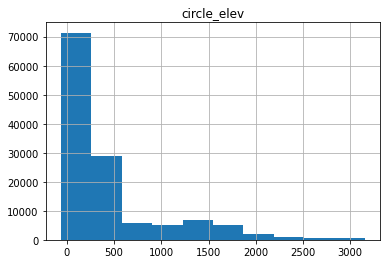

In [51]:
# Create histogram of elevations
paired_df_.hist(column='circle_elev')

In [52]:
# Same number of rows? Should be 109390
len(paired_df_.index)

127174

In [53]:
# sort dataframe on existing index
paired_df_.sort_values(['ui'], ascending=[True], inplace=True)

In [54]:
# Remove the temp key 
# Drop the temportary key 
paired_df_ = paired_df_.drop("temp_key_str",axis=1)

In [55]:
paired_df_.head()

,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,temp_max_value,precipitation_value,temp_avg,snow,snwd,am_rain,pm_rain,am_snow,pm_snow,circle_elev
124919,Hawai'i: Volcano N.P.,US-HI,19.433300,-155.283300,1955,1955-01-01,11.0,NaN,NaN,NaN,...,161.0,180.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1228.18
124920,Hawai'i: Volcano N.P.,US-HI,19.433300,-155.283300,1956,1955-12-31,11.0,NaN,NaN,NaN,...,189.0,290.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1228.18
124922,Hawai'i: Volcano N.P.,US-HI,19.433300,-155.283300,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,3,2,3,3,1228.18
124921,Hawai'i: Volcano N.P.,US-HI,19.433300,-155.283300,1968,1967-12-30,2.0,NaN,NaN,NaN,...,189.0,0.0,NaN,0.0,0.0,3,2,3,3,1228.18
124739,Hawai'i: Volcano,US-HI,19.516651,-155.299965,1973,1972-12-30,14.0,0.0,5.0,5.0,...,NaN,86.0,NaN,0.0,0.0,2,2,3,3,1551.44


In [56]:
### NEED A NEW WAY TO DO THIS TEST 
if get_offline_data:
    print('If from an offline source, check to make sure circle elevations are not being lost during merge:\n')
    print('NA in Merged:\n', paired_df_['circle_elev'].isna().value_counts())
    print('\n')
    print('NA in Offline:\n', offline_data['circle_elev'].isna().value_counts())

If from an offline source, check to make sure circle elevations are not being lost during merge:

NA in Merged:
 False    126995
True        179
Name: circle_elev, dtype: int64


NA in Offline:
 False    4584
Name: circle_elev, dtype: int64


In [57]:
print('Missing elevations:')
paired_df_['circle_elev'].isna().value_counts()

Missing elevations:


False    126995
True        179
Name: circle_elev, dtype: int64

In [58]:
print('How many elevations at sea level?')
paired_df_.loc[paired_df_['circle_elev'] == 0.0].shape

How many elevations at sea level?


(1519, 67)

## Save the output

In [59]:
#But First Some QA checks (Should be checked against the input file and previous notebooks)
paired_df_.shape

(127174, 67)

In [60]:
paired_df_['ui'].nunique()

65080

In [61]:
paired_df_.to_csv("../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations_"+time_now+".txt", 
                     sep='\t', 
                     compression='gzip',
                     index=False)